# Notebook to identify gene expression of genes from empty droplets before cellbender

**Created by :** Srivalli Kolla

**Created on :** 09 September, 2024

**Modified on :** 09 September, 2024

**Institute of SystemsImmunology, University of Würuburg**

Env : scanpy(Python 3.12.4)

# Importing packages

In [2]:
import anndata as ad
import scanpy as sc
import os
import datetime
import bbknn
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import median_abs_deviation

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
annoy               NA
asttokens           NA
attr                23.2.0
bbknn               1.6.0
cffi                1.16.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
defusedxml          0.7.1
distutils           3.12.4
django              5.0.6
executing           2.0.1
h5py                3.11.0
igraph              0.11.5
ipykernel           6.29.5
ipython_genutils    0.2.0
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
louvain             0.8.2
matplotlib          3.8.4
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.10.1
numpy               1.26.4
packaging           24.1
pandas    

# Data loading and Preprocessing

In [4]:
before_cb_raw = sc.read_h5ad(f'../../raw_data/raw_anndatas/dmd_merged_raw_before_cb_09_09_24.h5ad')
before_cb_raw

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10055673 × 32285
    obs: 'sample', 'genotype'

## Checking UMI

In [5]:
sample_names = before_cb_raw.obs['sample'].unique()

num_rows = 2
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

axs = axs.flatten()

color_palette = plt.cm.get_cmap('tab10')

for idx, sample_name in enumerate(sample_names):
   
    mask = before_cb_raw.obs['sample'] == sample_name
    sample_adata = before_cb_raw[mask].copy()

    sample_adata.obs['umi_counts'] = sample_adata.X.sum(axis=1)
    sample_adata = sample_adata[sample_adata.obs['umi_counts'].argsort()[::-1]]

    ax = axs[idx]
    color = color_palette(idx)
    ax.plot(range(1, len(sample_adata) + 1), sample_adata.obs['umi_counts'], marker='o', linestyle='-', label=sample_name, color=color, linewidth=1)
    ax.set_xlabel('Cell Rank')
    ax.set_ylabel('UMI Count')
    ax.set_title(f'UMI Count per Cell for Sample: {sample_name}')
    ax.set_xlim(0, 60000)
    ax.set_ylim(0, 1500)  
    ax.legend()

plt.tight_layout()

plt.show()

/tmp/ipykernel_193554/1192227536.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


##### *Description of UMI plots*
**X-axis (Cell Rank)**: This axis represents the rank of each cell in the dataset based on its UMI count. Cells are sorted from highest to lowest UMI counts, so the cell with the highest UMI count has the lowest rank and the cell with the lowest UMI count has the highest rank.

**Y-axis (UMI Count)**: This axis represents the number of Unique Molecular Identifiers (UMIs) detected in each cell. The UMI count indicates the level of gene expression or the amount of RNA present in each cell.

**Line Plot**: Each line in the plot represents a sample, and it shows how the UMI count changes as you move from the cell with the highest UMI count (lowest rank) to the cell with the lowest UMI count (highest rank) within that sample.


**Interpretation**:
A steep increase in the line indicates that there are a few cells with very high UMI counts, which contribute to the high UMI count for that sample.
A flat or gradually increasing line indicates that the UMI counts are distributed more evenly across cells in the sample.

All samples except B2_2 have umi higher than 200, so let us choose that as threshold

In [6]:
before_cb_raw

AnnData object with n_obs × n_vars = 10055673 × 32285
    obs: 'sample', 'genotype'

# Gene expression in Empty droplets - before outlier removal

In [7]:
before_cb_raw.var["mt"] = before_cb_raw.var_names.str.startswith("mt-")

before_cb_raw.var["ribo"] = before_cb_raw.var_names.str.startswith(("rps", "rpl"))

In [8]:
sc.pp.calculate_qc_metrics(
    before_cb_raw, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20],log1p=True)
before_cb_raw

AnnData object with n_obs × n_vars = 10055673 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
threshold = 200 ## From my umi graph 
before_cb_raw.obs['droplet_type'] = np.where(before_cb_raw.obs['total_counts'] < threshold, 'empty', 'cell')

print(before_cb_raw.obs['droplet_type'].value_counts())

droplet_type
empty    9679780
cell      375893
Name: count, dtype: int64


In [10]:
empty_droplets = before_cb_raw[before_cb_raw.obs['droplet_type'] == 'empty']
empty_droplets

View of AnnData object with n_obs × n_vars = 9679780 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'droplet_type'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [11]:
empty_droplet_expression = empty_droplets.X
mean_empty_droplet_expression = empty_droplet_expression.mean(axis=0)
mean_empty_droplet_expression

matrix([[1.9008647e-05, 1.6529301e-06, 3.0992439e-07, ..., 0.0000000e+00,
         0.0000000e+00, 7.6138320e-05]], dtype=float32)

In [12]:
empty_droplet_expr_df = pd.DataFrame(mean_empty_droplet_expression.T, index=before_cb_raw.var_names, columns=['Mean Expression'])
empty_droplet_expr_df = empty_droplet_expr_df.sort_values(by='Mean Expression', ascending=False)
empty_droplet_expr_df.head(20)

,Mean Expression
mt-Co1,0.056372
Malat1,0.037067
Gm42418,0.022497
mt-Co2,0.020429
mt-Co3,0.019523
mt-Atp6,0.015722
mt-Nd2,0.014190
Myl2,0.008555
mt-Cytb,0.008353
mt-Nd4,0.007553


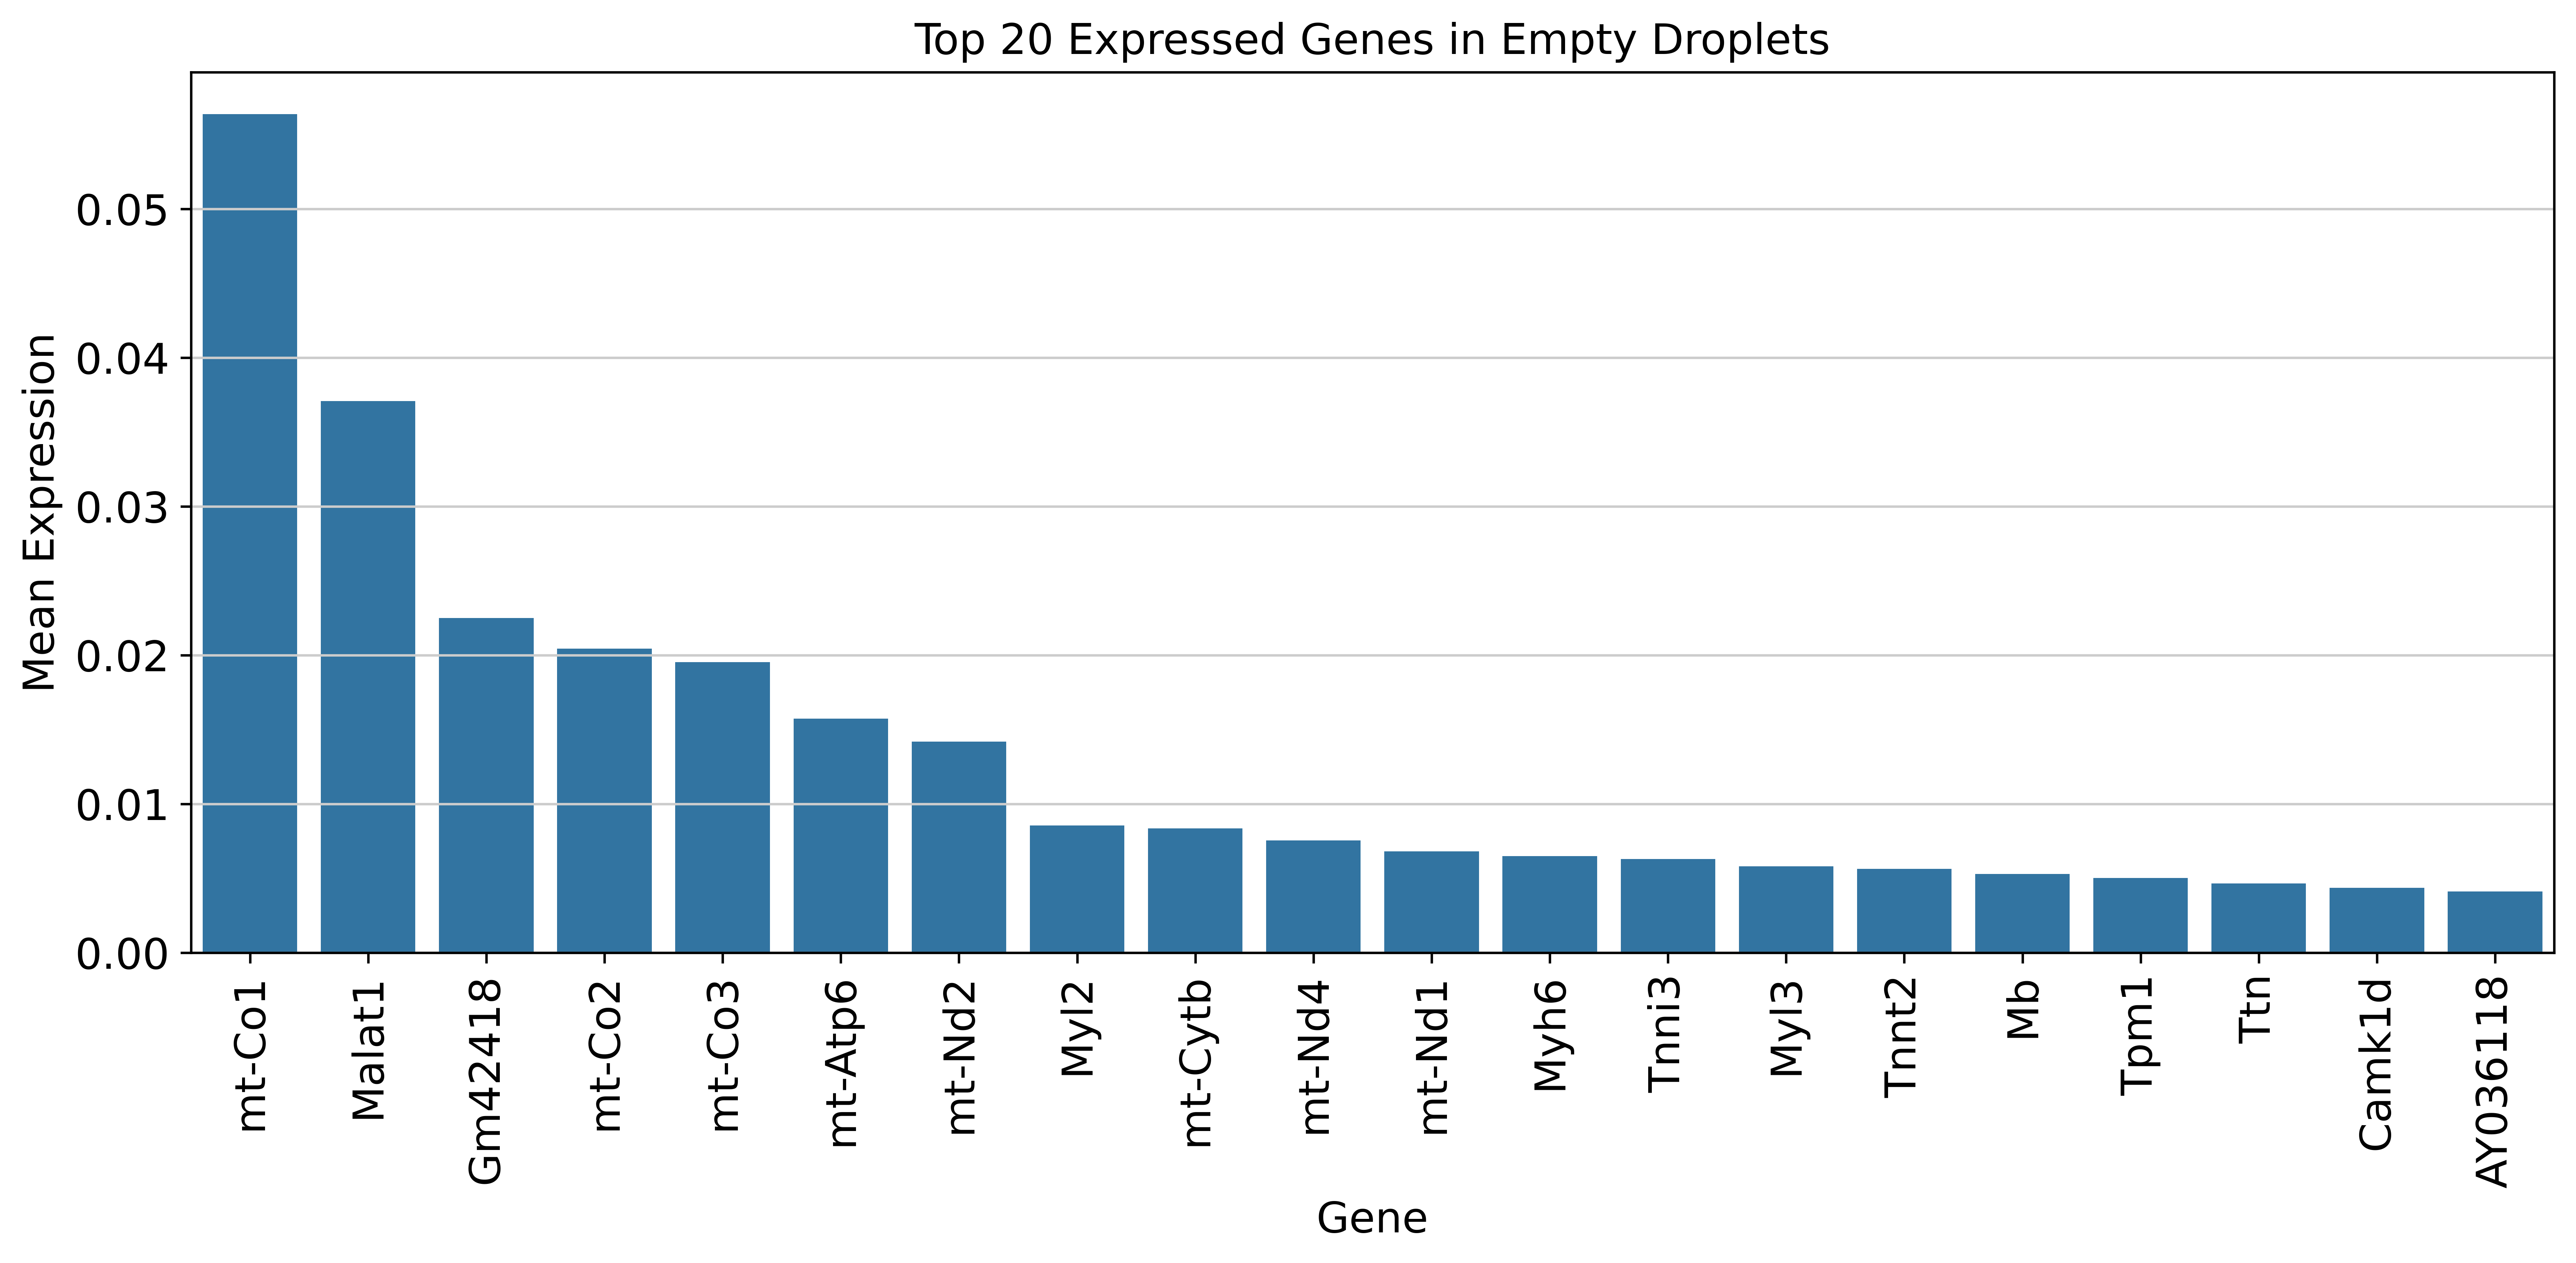

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(x=empty_droplet_expr_df.index[:20], y=empty_droplet_expr_df['Mean Expression'][:20])
plt.title('Top 20 Expressed Genes in Empty Droplets')
plt.xlabel('Gene')
plt.ylabel('Mean Expression')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Gene expression in Empty droplets - After outlier removal

As we observe tope expressed genes mostly are mt genes we would like to remove them.  In general we remove outliers having mt, rb genes and having kess counts and hence we removed them and observed top genes from those empty droplets

In [14]:
def is_outlier(empty_droplets, metric: str, nmads: int):
    M =empty_droplets.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [15]:
empty_droplets.obs["outlier"] = (
    is_outlier(empty_droplets, "log1p_total_counts", 5)
    | is_outlier(empty_droplets, "log1p_n_genes_by_counts", 5)
    | is_outlier(empty_droplets, "pct_counts_in_top_20_genes", 5)
)
empty_droplets.obs.outlier.value_counts()

/tmp/ipykernel_193554/1736518115.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  empty_droplets.obs["outlier"] = (
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


outlier
False    9672309
True        7471
Name: count, dtype: int64

In [16]:
empty_droplets.obs["mt_outlier"] = is_outlier(
    empty_droplets, "pct_counts_mt", 3) | (
   empty_droplets.obs["pct_counts_mt"] > 8
)
empty_droplets.obs.mt_outlier.value_counts()

mt_outlier
False    8401505
True     1278275
Name: count, dtype: int64

In [17]:
print(f"Total number of cells: {empty_droplets.n_obs}")
empty_droplets = empty_droplets[(~empty_droplets.obs.outlier) & (~empty_droplets.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {empty_droplets.n_obs}")

Total number of cells: 9679780
Number of cells after filtering of low quality cells: 8398842


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
sc.pp.highly_variable_genes(empty_droplets, subset= True, n_top_genes= 8000)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
empty_droplets.obs_names_make_unique()
empty_droplets

AnnData object with n_obs × n_vars = 8398842 × 18745
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'droplet_type', 'outlier', 'mt_outlier'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [20]:
sc.pp.normalize_total(empty_droplets, target_sum= 1e6)
sc.pp.log1p(empty_droplets)

normalizing counts per cell
    finished (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [21]:
empty_droplet_expression = empty_droplets.X
mean_empty_droplet_expression = empty_droplet_expression.mean(axis=0)
mean_empty_droplet_expression

matrix([[3.2898611e-06, 4.7031044e-06, 1.6449305e-06, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [22]:
empty_droplet_expr_df = pd.DataFrame(mean_empty_droplet_expression.T, index=empty_droplets.var_names, columns=['Mean Expression'])
empty_droplet_expr_df = empty_droplet_expr_df.sort_values(by='Mean Expression', ascending=False)
empty_droplet_expr_df.head(20)

,Mean Expression
Malat1,0.464330
Gm42418,0.259448
Myl2,0.101085
AY036118,0.054116
Camk1d,0.053464
Tnnc1,0.026879
Slc8a1,0.025760
Cox6c,0.025733
Zbtb20,0.024385
Cacna1c,0.023806


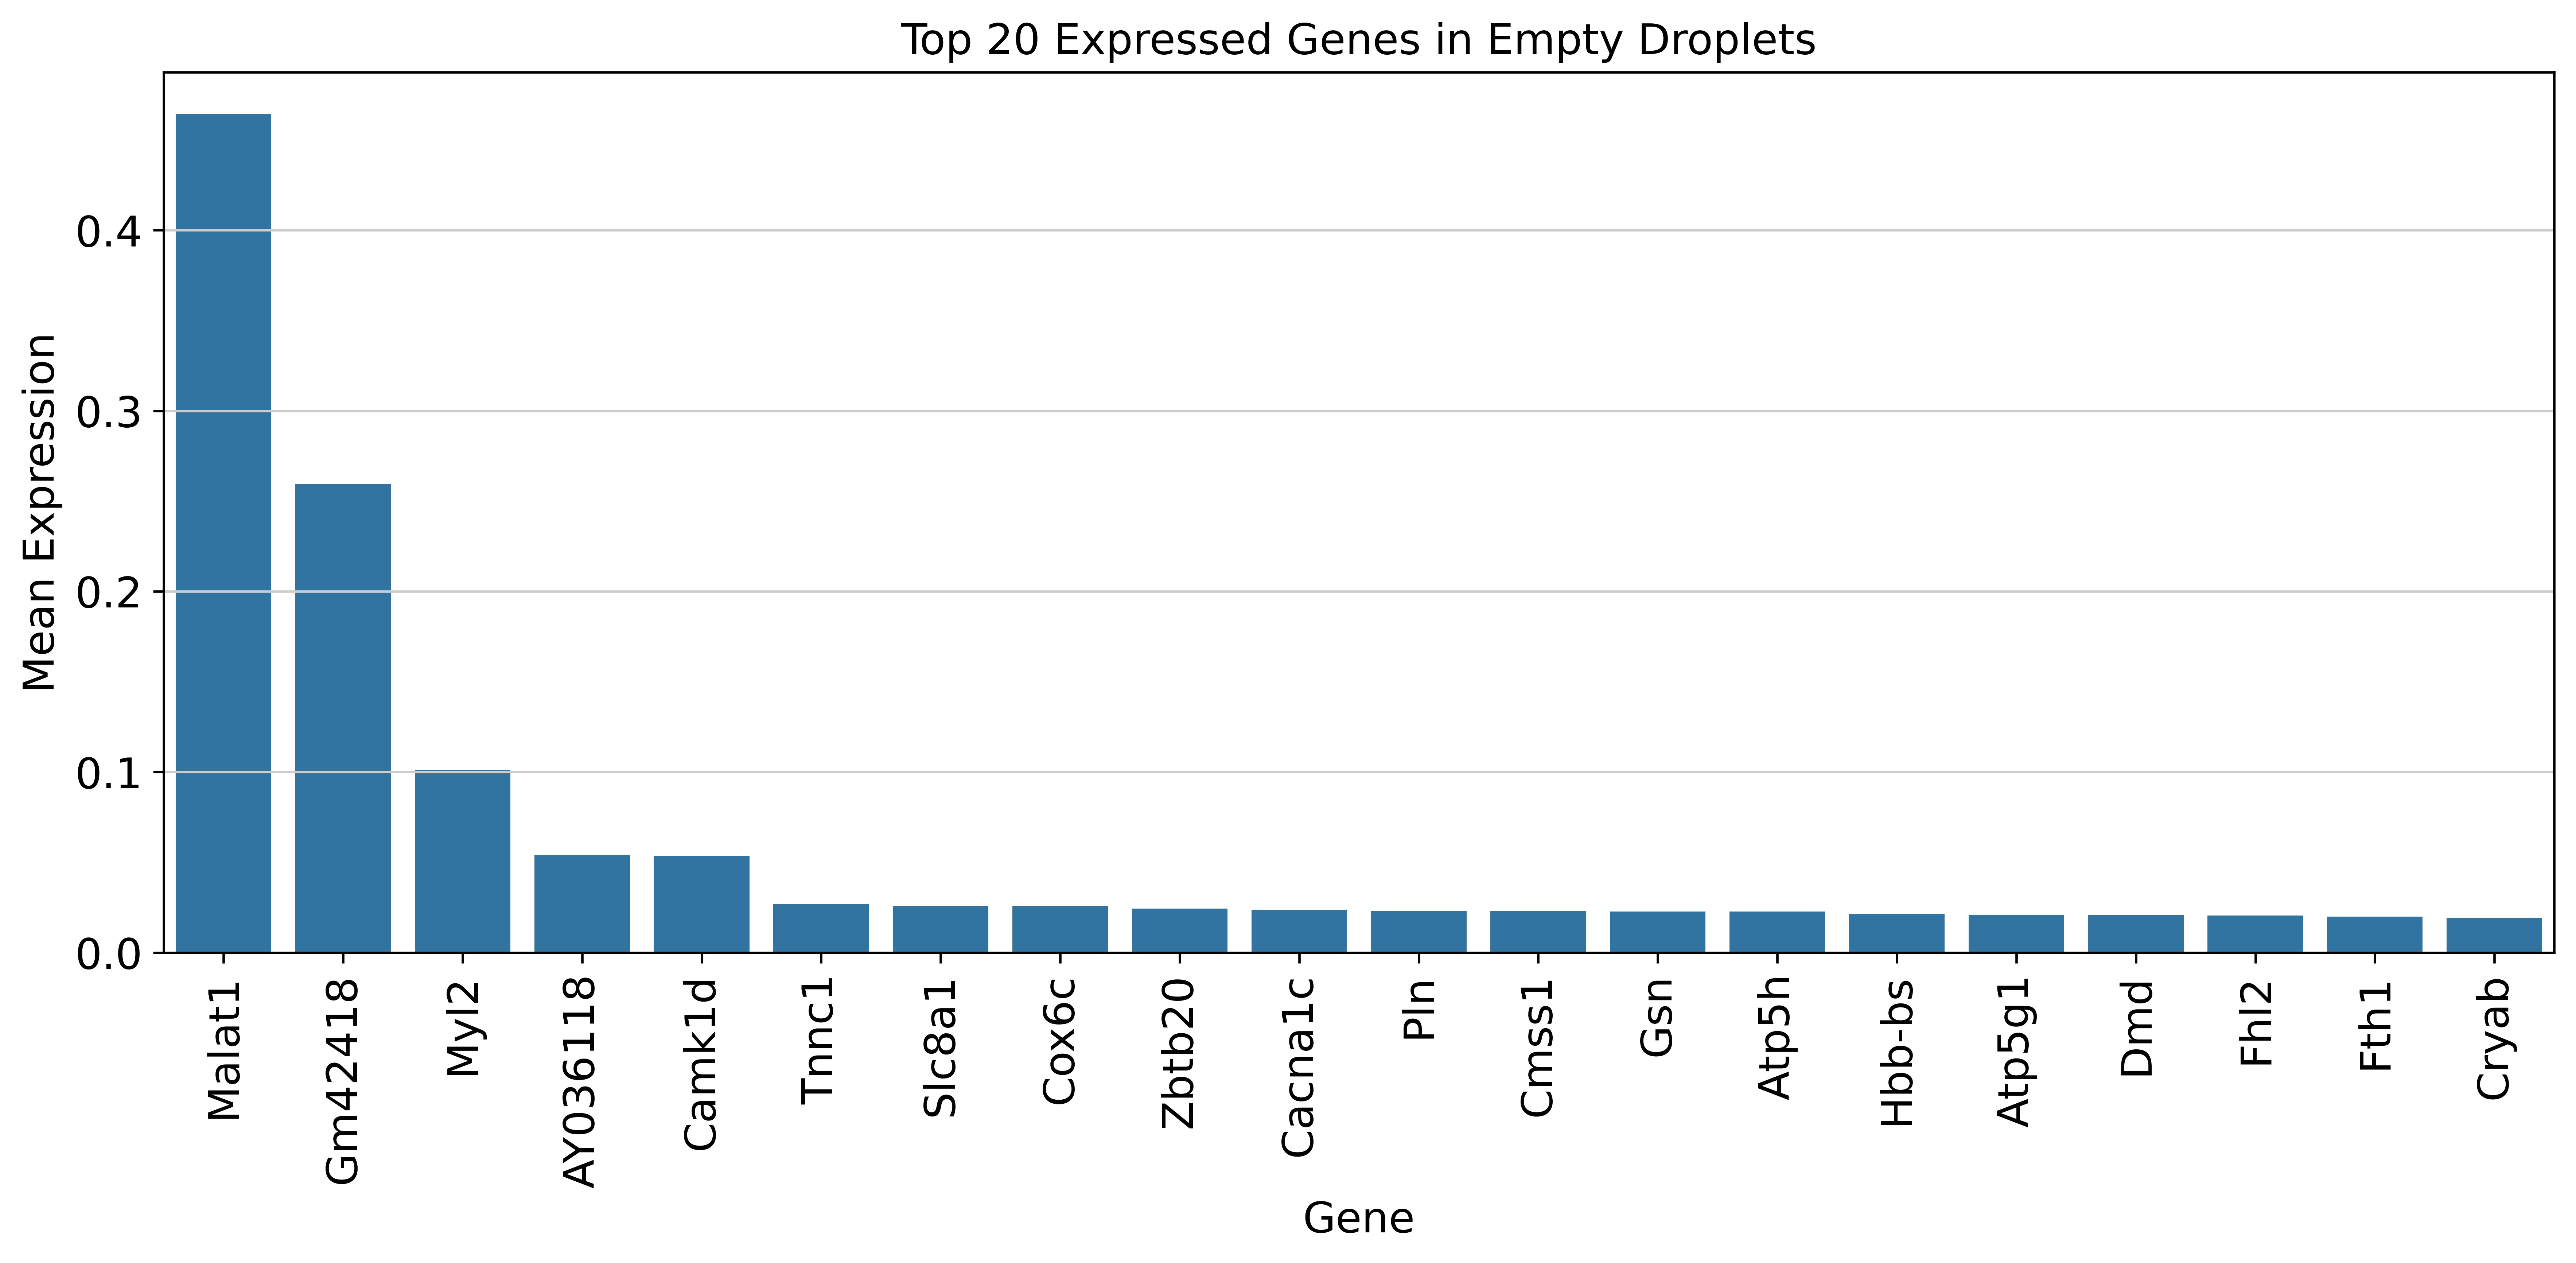

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(x=empty_droplet_expr_df.index[:20], y=empty_droplet_expr_df['Mean Expression'][:20])
plt.title('Top 20 Expressed Genes in Empty Droplets')
plt.xlabel('Gene')
plt.ylabel('Mean Expression')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()